In [3]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

In [19]:
# https://cs.stanford.edu/~zxie/textgen.pdf
# https://www.tensorflow.org/text/tutorials/transformer#set_up_the_tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU!!!!!!!!!!!!!!!!")
else:
    device = torch.device('cpu')
    print("CPU :(")

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequence
from transformers import GPT2LMHeadModel, \
                        TextDataset, \
                        DataCollatorForLanguageModeling, \
                        Trainer, \
                        TrainingArguments,\
                        GPT2Tokenizer

from tokenizers import ByteLevelBPETokenizer

import boto3

GPU!!!!!!!!!!!!!!!!


In [20]:
#load the dataset
#NOTE THAT SINCE THIS CORPUS IS ONLY IN LOWERCASE, YOU NEED TO FEED THE DATA AS LOWERCASES OR YOU WILL NOT GET *ACCURATE* TRANSLATIONS
client = boto3.client('s3')
df = pd.read_csv("./data.csv", delimiter = "\t", names=['turkish','english'])
df = df[:1000]

In [21]:
#verify that the dataset has been loaded

print(df.columns)
print(df.head())
print(df.shape)

Index(['turkish', 'english'], dtype='object')
                                             turkish  \
0  emekli üyeler kongre'nin şu sıralar çete savaş...   
1  entellektüellik , klas , asalet veya hikaye il...   
2  hangisi olduğunu tahmin edebildiniz mi ? şirke...   
3  pek uzak yerlere seyahat edemez veya belli bir...   
4                                 heyecanlanmıştım .   

                                             english  
0  retiring members nowadays say that it 's becom...  
1  no sophistication , no class , no dignity , no...  
2                     did you guess it ? companies .  
3  you ca n't travel very far or venture too far ...  
4                                    i was excited .  
(1000, 2)


In [31]:
%%time
# Initialize the GPT-2 tokenizer
tokenizer = ByteLevelBPETokenizer()
tokenizer.unk_token = "<unk>"
tokenizer.pad_token = "<pad>"
tokenizer.enable_padding(length=256, pad_token="<pad>", direction="right")
tokenizer.enable_truncation(max_length=256)

# append the turkish to the english and add the special tokens
df['turkish'] = df['turkish'].apply(lambda x: x.lower())
df['english'] = df['english'].apply(lambda x: x.lower())
df['turkish'] = df['turkish'].apply(lambda x: "<s> " + x + " </s>")
df['english'] = df['english'].apply(lambda x: "<s> " + x + " </s>")

# Train the tokenizer on the dataset for english and turkish

en_tr = df['turkish'].tolist() + df['english'].tolist()
tokenizer.train_from_iterator(en_tr, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
], show_progress=True)

#save model 
tokenizer.save_model("./tokenizer")

tokenizer = GPT2Tokenizer.from_pretrained("./tokenizer")
tokenizer.add_special_tokens({
    "eos_token": "</s>",
    "bos_token": "<s>",
    "unk_token": "<unk>",
    "pad_token": "<pad>",
    "mask_token": "<mask>"
})

print(tokenizer.encode("test if this is working"))

######################################################################
#TODO: ADD <NUM> TOKEN SO THAT THE MODEL CAN KEEP THE NUMBERS THE SAME
######################################################################




[5672, 567, 399, 356, 1677]
CPU times: user 3.71 s, sys: 1.79 s, total: 5.5 s
Wall time: 1.01 s


In [32]:
# Tokenize the dataset
def tokenize_text(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    return tokenized_text

# Tokenize the dataset
tr_tokens = df['turkish'].apply(lambda x: tokenize_text(x))
en_tokens = df['english'].apply(lambda x: tokenize_text(x))
print(tr_tokens[0])

# #convert to torch tensors   
# tr_input_ids = tr_tokens.apply(lambda x: torch.tensor(x.ids))
# tr_attention_mask = tr_tokens.apply(lambda x: torch.tensor(x.attention_mask))
# en_input_ids = en_tokens.apply(lambda x: torch.tensor(x.ids))
# en_attention_mask = en_tokens.apply(lambda x: torch.tensor(x.attention_mask))

[0, 0, 0, 0, 73, 482, 456, 6223, 700, 75, 299, 11, 3096, 943, 6368, 5324, 73, 1279, 1928, 6765, 4559, 306, 269, 2, 2, 2, 2]


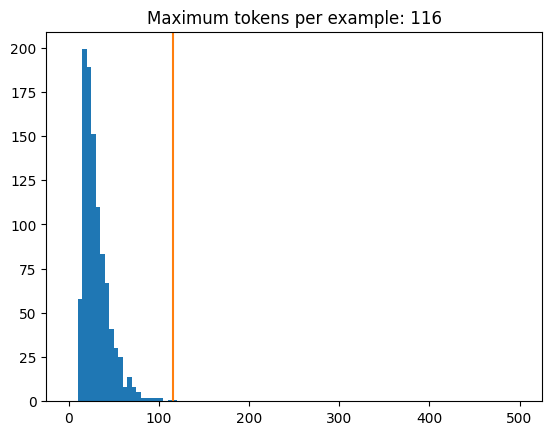

In [33]:
lengths = []

for sample in tr_tokens:
    try:
        lengths.append(len(sample))
    except:
        print(sample)
        break 
plt.hist(lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [12]:
%%time
# create a custom dataset from the 4 tensors
class TranslationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, target_ids, target_attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.target_ids = target_ids
        self.target_attention_masks = target_attention_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        input_id = self.input_ids[index]
        attention_mask = self.attention_masks[index]
        target_id = self.target_ids[index]
        target_attention_mask = self.target_attention_masks[index]

        return {
            "input_ids": input_id,
            "attention_mask": attention_mask,
            "target_ids": target_id,
            "target_attention_mask": target_attention_mask
        }

#create the dataset
dataset = TranslationDataset(en_input_ids, en_attention_mask, tr_input_ids, tr_attention_mask)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#get the first batch
batch = next(iter(dataloader))
print(batch['input_ids'].shape)

torch.Size([32, 256])
CPU times: user 570 µs, sys: 13.6 ms, total: 14.1 ms
Wall time: 31.1 ms
